In [2]:
!pip install opencv-python

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
dataset='dataset'
imagePaths=list(paths.list_images(dataset))

In [5]:
data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)

C:\Users\soham\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [7]:
data.shape

(4238, 224, 224, 3)

In [8]:
labels

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

In [9]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [10]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [11]:

aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [12]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

9412608/9406464 [==============================] - 5s 0us/step


In [13]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

__________________________________________________________________________________________________
block_9_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_9_depthwise[0][0]          
__________________________________________________________________________________________________
block_9_depthwise_relu (ReLU)   (None, 14, 14, 384)  0           block_9_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_9_project (Conv2D)        (None, 14, 14, 64)   24576       block_9_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_9_project_BN (BatchNormal (None, 14, 14, 64)   256         block_9_project[0][0]            
__________________________________________________________________________________________________
block_9_add (Add)               (None, 14, 14, 64)   0           block_8_add[0][0]                
          

In [14]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

In [15]:
model=Model(inputs=baseModel.input,outputs=headModel)

In [16]:
for layer in baseModel.layers:
    layer.trainable=False

In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

block_15_depthwise_BN (BatchNor (None, 7, 7, 960)    3840        block_15_depthwise[0][0]         
__________________________________________________________________________________________________
block_15_depthwise_relu (ReLU)  (None, 7, 7, 960)    0           block_15_depthwise_BN[0][0]      
__________________________________________________________________________________________________
block_15_project (Conv2D)       (None, 7, 7, 160)    153600      block_15_depthwise_relu[0][0]    
__________________________________________________________________________________________________
block_15_project_BN (BatchNorma (None, 7, 7, 160)    640         block_15_project[0][0]           
__________________________________________________________________________________________________
block_15_add (Add)              (None, 7, 7, 160)    0           block_14_add[0][0]               
                                                                 block_15_project_BN[0][0]        
__________

In [18]:
learning_rate=0.001
Epochs=20
BS=12

opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)


model.save('mobilenet_v2.model')

Epoch 1/20
282/282 [==============================] - 116s 413ms/step - loss: 0.2220 - accuracy: 0.9142 - val_loss: 0.0889 - val_accuracy: 0.9634
Epoch 2/20
282/282 [==============================] - 98s 347ms/step - loss: 0.1361 - accuracy: 0.9449
Epoch 3/20
282/282 [==============================] - 90s 318ms/step - loss: 0.0992 - accuracy: 0.9621
Epoch 4/20
282/282 [==============================] - 88s 312ms/step - loss: 0.1041 - accuracy: 0.9600
Epoch 5/20
282/282 [==============================] - 89s 314ms/step - loss: 0.0905 - accuracy: 0.9657
Epoch 6/20
282/282 [==============================] - 88s 314ms/step - loss: 0.0825 - accuracy: 0.9704
Epoch 7/20
282/282 [==============================] - 90s 320ms/step - loss: 0.0813 - accuracy: 0.9686
Epoch 8/20
282/282 [==============================] - 111s 393ms/step - loss: 0.0706 - accuracy: 0.9725
Epoch 9/20
282/282 [==============================] - 92s 326ms/step - loss: 0.0686 - accuracy: 0.9760
Epoch 10/20
282/282 [========

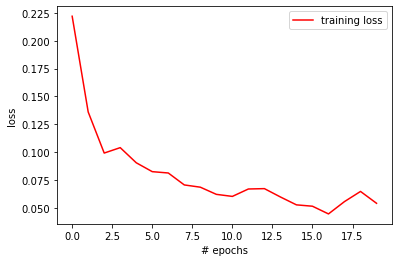

In [19]:
from matplotlib import pyplot as plt

plt.plot(H.history['loss'],'r',label='training loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

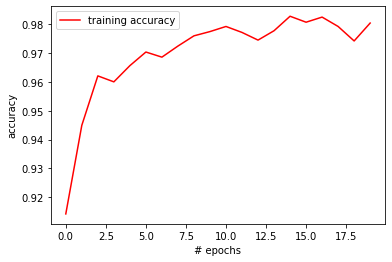

In [20]:
plt.plot(H.history['accuracy'],'r',label='training accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [21]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       395
without_mask       0.99      1.00      0.99       453

    accuracy                           0.99       848
   macro avg       0.99      0.99      0.99       848
weighted avg       0.99      0.99      0.99       848

